In [1]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmc
import cartopy.crs as ccrs
import os
from cartopy import geodesic as cgeod
from geopy.distance import geodesic 
from tqdm import tqdm
import warnings
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, Normalize
from multiprocess import Pool
import cartopy.feature as cfeature
import scipy.stats as stats
from glob import glob
## my own directory
os.chdir("/g/data/k10/dl6968/Semi-variogram_AU/")


In [2]:
from gstools import CovModel

class Stab(CovModel):
    def variogram(self, r):
        
        return self.nugget + self.sill * (1 - np.exp(-(3 * r) / self.len_scale))

In [3]:
params={     
    'axes.labelsize'  : '16',   
    'axes.titlesize'  : '16',  
    'xtick.labelsize' :'16',
    'ytick.labelsize' :'16',    
    'lines.linewidth' : '2' ,   
    'legend.fontsize' : '12', 
    'figure.figsize'   : '12, 7'    
}
plt.rcParams.update(params)

In [4]:
df = pd.read_csv("./data/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'./data/all_AU_p90_1980/{stn_id}_pair_scale_moving_list_all_events.csv'):
        exclude_stn.append(stn_id)
## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

In [5]:
# Define seasons based on month
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return "DJF"
    elif month in [3, 4, 5]:
        return "MAM"
    elif month in [6, 7, 8]:
        return "JJA"
    elif month in [9, 10, 11]:
        return "SON"

# Method: weighted bins

In [6]:
bin_files = sorted(glob("./data/all_AU_p90_1980/*_pair_bins_moving_list_all_events.csv"))
fit_model = Stab(dim=2)  # Choose model type (Exponential, Spherical, Gaussian, etc.)

# Function to compute weighted mean of gamma for each bin
def weighted_mean_gamma(x):
    if np.sum(x["Norm_Weight"]) > 0:
        return np.sum(x["gamma"] * x["Norm_Weight"]) / np.sum(x["Norm_Weight"])
    else: 
        return 0
def bins_to_season(file):
    
    df_bins = pd.read_csv(file, usecols=lambda col: not col.startswith("Unnamed"))
    df_bins = df_bins[(df_bins["y_fit"]>0)] 
    df_bins["Date"] = pd.to_datetime(df_bins["Date"])
    df_bins["Season"] = df_bins["Date"].apply(get_season)
    df_bins["Tot"] = df_bins["N11"] + df_bins["N10"]
    mean_stations_per_bin = df_bins.groupby(["Season", "Bins"])["Tot"].transform("mean")
    df_bins["Raw_Weight"] = df_bins["Tot"] / mean_stations_per_bin
    ## normalise weight
    df_bins["Norm_Weight"] = df_bins.groupby(["Season", "Bins"])["Raw_Weight"].transform(lambda x: x / x.sum())
    
    
    # Apply the weighted mean function per Season & Bin
    ivw_gamma = df_bins.groupby(["Season", "Bins"]).apply(weighted_mean_gamma).reset_index(name="IVW_Gamma")
    bins_yfit_dict = {}
    bins_scale_dict = {}
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        bins = ivw_gamma[ivw_gamma["Season"]==seasons]["Bins"].values
        gamma = ivw_gamma[ivw_gamma["Season"]==seasons]["IVW_Gamma"].values
        if len(gamma)==0:
            bins = np.arange(1,720,20)
            y_fit = np.zeros_like(bins)
            gamma = np.zeros_like(bins)
            scale = 0
            
        else:
            try:
                _ = fit_model.fit_variogram(bins, gamma, sill=0.5-0.025, nugget=0.025)
                y_fit = fit_model.variogram(bins)
                scale = fit_model.len_scale
            except RuntimeError:
                y_fit = np.zeros_like(bins)
                scale = 0
        bins_yfit_dict[seasons+"_yfit"] = y_fit
        bins_yfit_dict[seasons+"_gamma"] = gamma    
        bins_scale_dict[seasons] = scale
    bins_yfit_dict["Bins"] = bins
    df_season_bins = pd.DataFrame.from_dict(bins_yfit_dict)
    df_season_bins.to_csv(file.replace("pair", "season"))
    df_season_scale = pd.DataFrame.from_dict(bins_scale_dict, orient="index", columns=["scale"])
    df_season_scale.to_csv(file.replace("pair_bins", "season_scale"))

In [7]:
max_pool = 24
with Pool(max_pool) as p:
    pool_outputs = list(tqdm(
            p.imap(bins_to_season,
                   bin_files),
        total=len(bin_files),
        position=0, leave=True,  desc="Processing seasonality",
    )
    )
p.join()

Processing seasonality: 100%|██████████| 2918/2918 [00:39<00:00, 74.17it/s]


In [8]:
season_weight_dict = {"DJF":[], "MAM":[], "JJA":[], "SON":[]}
for spec_id in tqdm(df["ID"],leave=True, position=0):
    df_scale = pd.read_csv(f"./data/all_AU_p90_1980/{spec_id}_season_scale_moving_list_all_events.csv",index_col=0)
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        season_weight_dict[seasons].append( df_scale.loc[seasons].values)

100%|██████████| 2918/2918 [00:06<00:00, 444.49it/s]


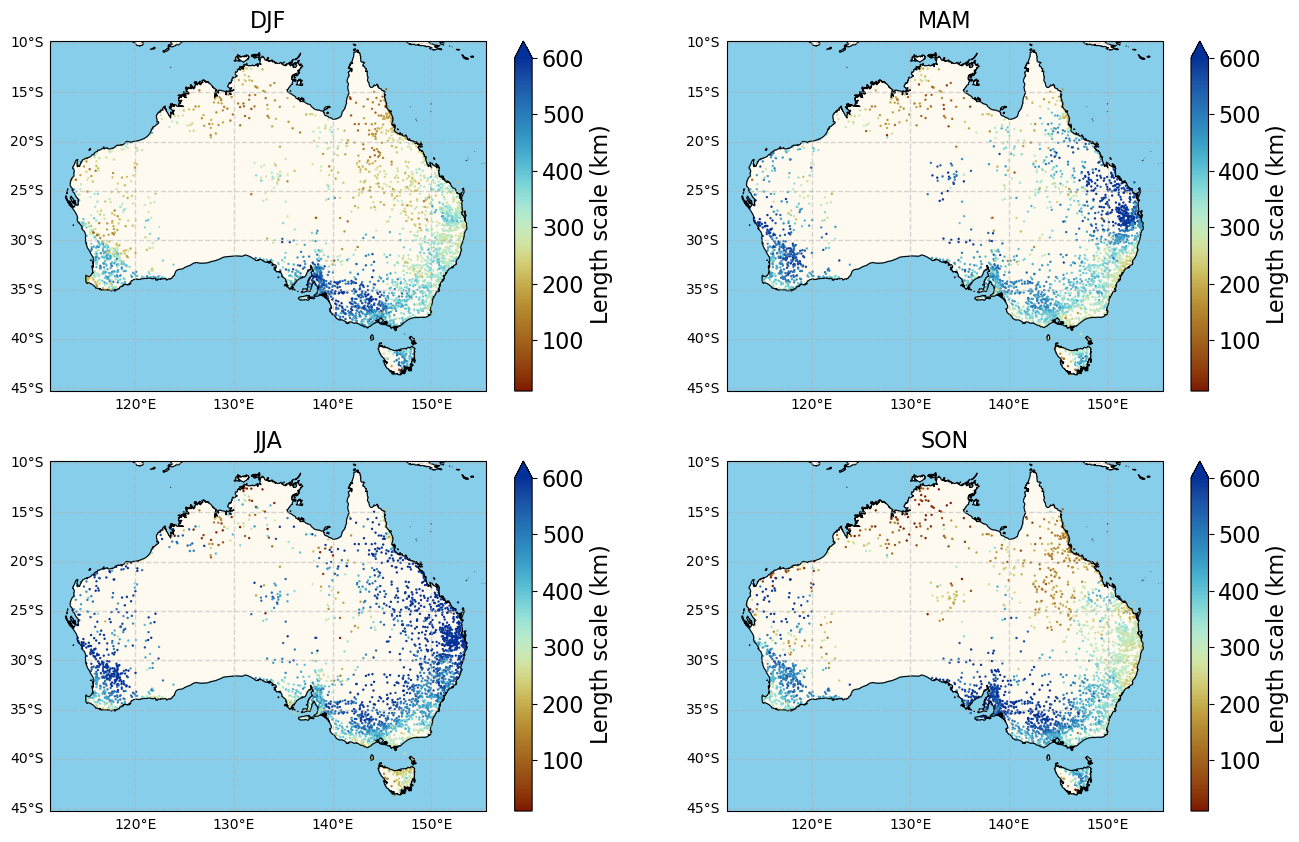

In [10]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = "cmc.roma"
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["DJF"], cmap=cmap, vmin=10,vmax=600, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["MAM"], cmap=cmap, vmin=10,vmax=600, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["JJA"], cmap=cmap, vmin=10,vmax=600,
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= season_weight_dict["SON"],  cmap=cmap, vmin=10,vmax=600,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
# plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")

## Method 1.1: just calculate the means

In [17]:
season_dict = {}
for spec_id in tqdm(df["ID"],leave=True, position=0):
    df_scale = pd.read_csv(f"./data/all_AU_p90_1980/{spec_id}_pair_scale_moving_list_all_events.csv", usecols=lambda col: not col.startswith("Unnamed"))
    df_scale["Date"] = pd.to_datetime(df_scale["extreme_dates"])
    df_scale["Season"] = df_scale["Date"].apply(get_season)
    df_scale["scale"] = df_scale["scale"].replace(0, np.nan)

    seasons = {season: group["scale"].tolist() for season, group in df_scale.groupby("Season")}
    season_dict[str(spec_id)] = seasons

100%|██████████| 2918/2918 [00:32<00:00, 88.87it/s] 


In [21]:
djf_mean = [np.nanmedian(season_dict[str(spec_id)]["DJF"]) if "DJF" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
mam_mean = [np.nanmedian(season_dict[str(spec_id)]["MAM"]) if "MAM" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
jja_mean = [np.nanmedian(season_dict[str(spec_id)]["JJA"]) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
son_mean = [np.nanmedian(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]


/jobfs/136843912.gadi-pbs/ipykernel_3677275/1563790501.py:3: RuntimeWarning: All-NaN slice encountered
  jja_mean = [np.nanmedian(season_dict[str(spec_id)]["JJA"]) if "JJA" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
/jobfs/136843912.gadi-pbs/ipykernel_3677275/1563790501.py:4: RuntimeWarning: All-NaN slice encountered
  son_mean = [np.nanmedian(season_dict[str(spec_id)]["SON"]) if "SON" in season_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]


In [19]:
# Define color segments
colors = [
    (0, "brown"),    
    (0.3, "gold"), 
    (0.7, "lightblue"),
    (1, "royalblue")      
]

# Create custom colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)


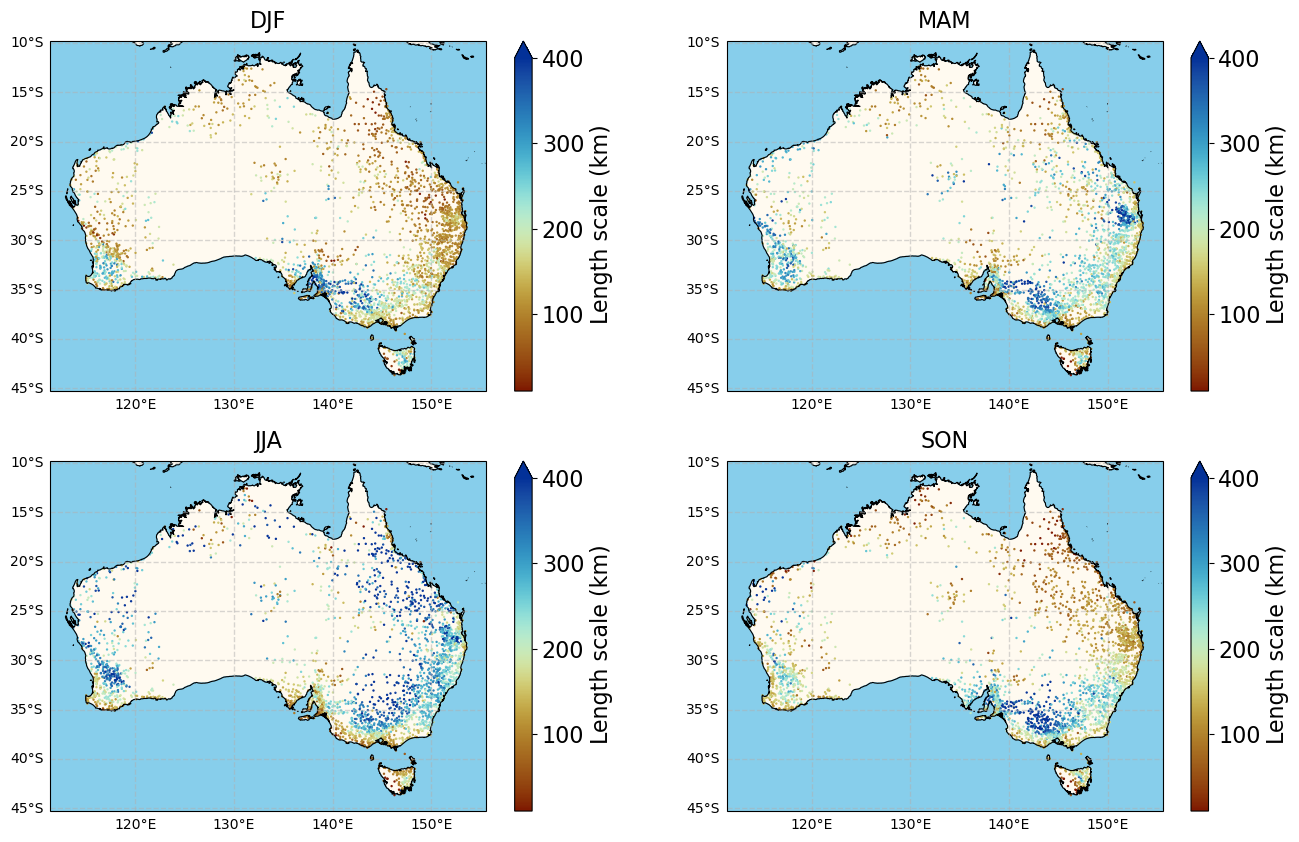

In [22]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = "cmc.roma"
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= djf_mean, cmap=cmap, vmin=10,vmax=400, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= mam_mean, cmap=cmap, vmin=10,vmax=400, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= jja_mean, cmap=cmap, vmin=10,vmax=400,
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= son_mean,  cmap=cmap, vmin=10,vmax=400,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
# plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")

## Method 1.2: use the bins

In [11]:
def calc_ratio_gamma(N11,N10):
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        ratio = np.where(N10 + N11 != 0, 0.5 * (N10 / (N10 + N11)), np.nan)

    return ratio
def calc_alpha(gamma_fit,bins_fit,bins):
    # gamma_fit = gamma[~np.isnan(gamma)]
    # bins_fit = bins[~np.isnan(bins)]
    y_fit = 0
    scale = 0
    try:
        _ = fit_model.fit_variogram(bins_fit, gamma_fit,  nugget=0.025, sill=0.5-0.025)#)#
        y_fit = fit_model.variogram(bins)
        scale = fit_model.len_scale
    except RuntimeError:
        try: 
            ## adjust the cape a little bit so the code can pass through
            _ = fit_model.fit_variogram(bins_fit, gamma_fit,  nugget=0, sill=0.51)#)#
            y_fit = fit_model.variogram(bins)
            scale = fit_model.len_scale
        except RuntimeError:
            y_fit,alpha = fit_sci_curve(bins_fit,gamma_fit,bins)
            # no_fit_days.append(days)
            scale = alpha
    return y_fit, scale

In [12]:
from scipy.optimize import curve_fit

# Define the piecewise function
def custom_curve(h, c, b, alpha):
    if np.isscalar(h):
        # Handle the scalar case
        if h == 0:
            return 0
        else:
            return c + b * (1 - np.exp(-3 * h / alpha))
    else:
        # Handle array inputs
        return np.where(h == 0, 0, c + b * (1 - np.exp(-3 * h / alpha)))

def fit_sci_curve(h_values, y_values,bins):

    # Use curve_fit to fit the custom function to the data
    # Initial guess for c, b, and alpha
    initial_guess = [0, 0.5, 5]  
    
    # Perform the curve fitting
    params, covariance = curve_fit(custom_curve, h_values, y_values, p0=initial_guess)
    
    # Extract the fitted parameters
    c_fitted, b_fitted, alpha_fitted = params
    
    y_fit = custom_curve(bins, c_fitted, b_fitted, alpha_fitted)
    return y_fit, alpha_fitted

In [13]:
def calc_scale_alpha(N11, N10):
    gamma = calc_ratio_gamma(N11, N10)        
    gamma_fit = gamma.copy()
    bins_fit = bins.copy().astype(float)
    gamma_fit[N11+N10<=2] = np.nan
    bins_fit[N11+N10<=2] = np.nan
    ## make sure start with zeros
    # gamma_fit[0] = 0
    # bins_fit[0] =0
    ## remove NaNs 
    gamma_fit1 = gamma_fit[~np.isnan(gamma_fit)]
    bins_fit1 = bins_fit[~np.isnan(bins_fit)]
    ## in case all NaNs occured
    if len(gamma_fit1)<=2:
        y_fit = np.zeros_like(bins)
        scale = 0
    else:
        y_fit, scale = calc_alpha(gamma_fit1, bins_fit1, bins)
    return y_fit, scale

In [14]:
# Define distance bins
bins = np.arange(1, 720, 20)
fit_model = Stab(dim=2)#gs.Stable(dim=1)


In [15]:
bins_scale_dict = {}
bins_yfit_dict = {}

for spec_id in tqdm(df["ID"],leave=True, position=0):

    df_bins = pd.read_csv(f"./data/all_AU_p90_1980/{spec_id}_pair_bins_moving_list_all_events.csv", usecols=lambda col: not col.startswith("Unnamed"))
    df_bins = df_bins[(df_bins["y_fit"]>0)]
    df_bins["Date"] = pd.to_datetime(df_bins["Date"])
    df_bins["Season"] = df_bins["Date"].apply(get_season)
    # Initialize nested dictionaries if not present
    bins_yfit_dict.setdefault(str(spec_id), {})
    bins_scale_dict.setdefault(str(spec_id), {})
    # Group by Season and Bins and sum N11 and N10
    seasonal_sum = df_bins.groupby(['Season', 'Bins'], as_index=False)[['N11', 'N10']].mean()
    for seasons in ["DJF", "MAM", "JJA", "SON"]:
        
        N11 = seasonal_sum[seasonal_sum["Season"]==seasons]["N11"].values
        N10 = seasonal_sum[seasonal_sum["Season"]==seasons]["N10"].values
        bins_yfit_dict[str(spec_id)][seasons], bins_scale_dict[str(spec_id)][seasons] = calc_scale_alpha(N11, N10)

100%|██████████| 2918/2918 [03:07<00:00, 15.60it/s]


In [16]:
id_list = []
djf_list = []
mam_list = []
jja_list = []
son_list = []
for spec_id in tqdm(df["ID"],leave=True, position=0):
    id_list.append(spec_id)
    djf_list.append(bins_scale_dict[str(spec_id)]["DJF"])
    mam_list.append(bins_scale_dict[str(spec_id)]["MAM"])
    jja_list.append(bins_scale_dict[str(spec_id)]["JJA"])
    son_list.append(bins_scale_dict[str(spec_id)]["SON"])

100%|██████████| 2918/2918 [00:00<00:00, 215425.68it/s]


In [17]:
csv_scale_dict = {"ID": id_list, "DJF": djf_list, "MAM": mam_list, "JJA": jja_list, "SON": son_list}
df1 = pd.DataFrame.from_dict(csv_scale_dict)
df1.to_csv("./data/seasonality/all_season_scales_1980.csv")

In [18]:
for spec_id in tqdm(df["ID"],leave=True, position=0):
    df2 = pd.DataFrame.from_dict(bins_yfit_dict[str(spec_id)])
    df2.to_csv(f"./data/seasonality/{spec_id}_season_yfit_1980.csv")

100%|██████████| 2918/2918 [00:11<00:00, 247.53it/s]


In [31]:
djf_scale = [bins_scale_dict[str(spec_id)]["DJF"] if "DJF" in bins_scale_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
mam_scale = [bins_scale_dict[str(spec_id)]["MAM"] if "MAM" in bins_scale_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
jja_scale = [bins_scale_dict[str(spec_id)]["JJA"] if "JJA" in bins_scale_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]
son_scale = [bins_scale_dict[str(spec_id)]["SON"] if "SON" in bins_scale_dict[str(spec_id)].keys() else np.nan for spec_id in df["ID"]]

(-45.0, -9.0)

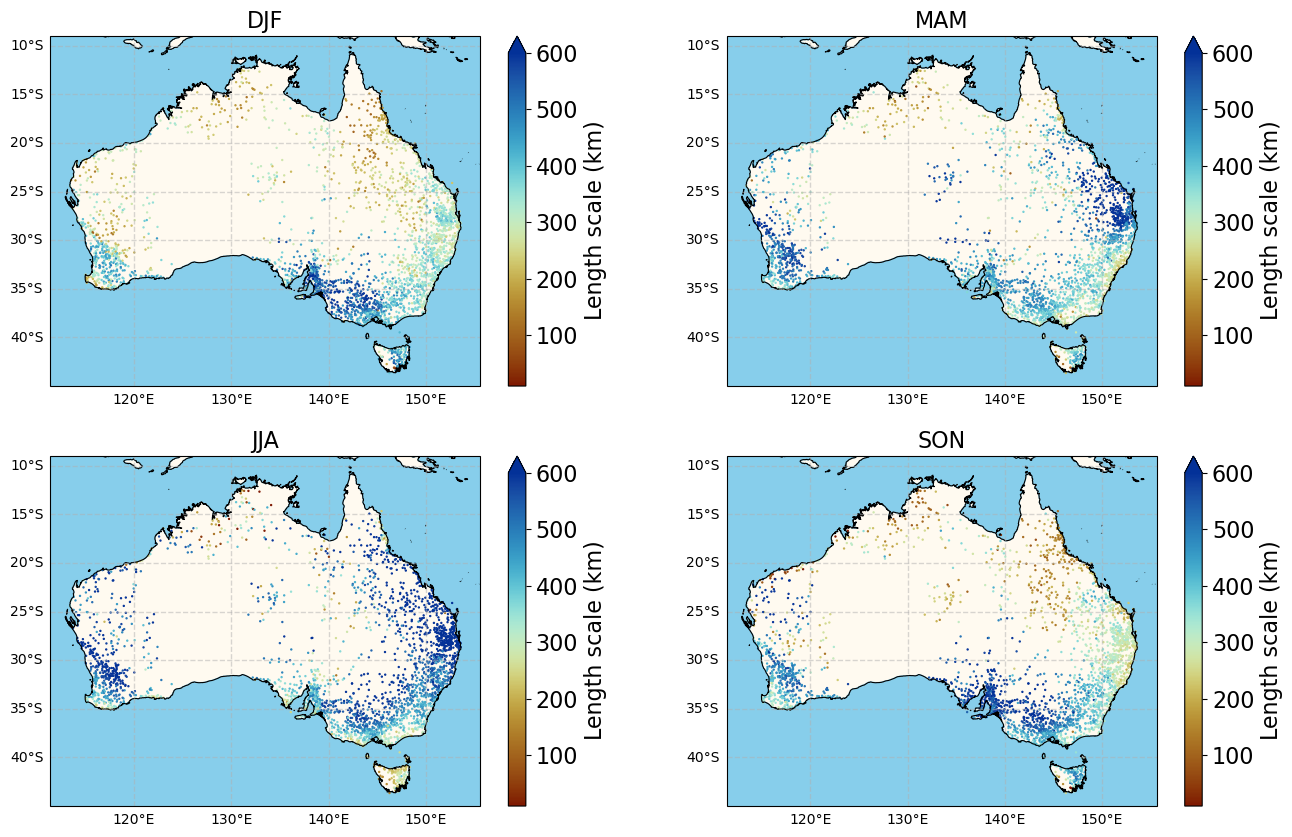

In [33]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(221, projection=ccrs.PlateCarree())
cmap = "cmc.roma"
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= djf_scale, cmap=cmap, vmin=10,vmax=600, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax1.coastlines('10m', color="black",linewidth=0.8)
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax1.set_title("DJF")
ax1.add_feature(cfeature.LAND, color='floralwhite')  
ax1.add_feature(cfeature.OCEAN, color='skyblue')  
ax1.set_ylim([-45,-9])

ax2 = fig.add_subplot(222, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= mam_scale, cmap=cmap, vmin=10,vmax=600, 
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax2.coastlines('10m', color="black",linewidth=0.8)
gl = ax2.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax2.set_title("MAM")
ax2.add_feature(cfeature.LAND, color='floralwhite')  
ax2.add_feature(cfeature.OCEAN, color='skyblue')  
ax2.set_ylim([-45,-9])

ax3 = fig.add_subplot(223, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= jja_scale, cmap=cmap, vmin=10,vmax=600,
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax3.coastlines('10m', color="black",linewidth=0.8)
gl = ax3.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax3.set_title("JJA")
ax3.add_feature(cfeature.LAND, color='floralwhite')  
ax3.add_feature(cfeature.OCEAN, color='skyblue')  
ax3.set_ylim([-45,-9])

ax4 = fig.add_subplot(224, projection=ccrs.PlateCarree())
plt.scatter(df["Longitude"], df["Latitude"], s=0.5, c= son_scale,  cmap=cmap, vmin=10,vmax=600,  
            transform=ccrs.PlateCarree())
cbar = plt.colorbar(extend="max")
cbar.ax.set_ylabel("Length scale (km)")
ax4.coastlines('10m', color="black",linewidth=0.8)
gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
ax4.set_title("SON")
ax4.add_feature(cfeature.LAND, color='floralwhite')  
ax4.add_feature(cfeature.OCEAN, color='skyblue')  
ax4.set_ylim([-45,-9])
# plt.savefig("AU_seasonality.png", dpi=200, bbox_inches="tight")

## Seasonality

In [81]:
df = pd.read_csv("/g/data/k10/dl6968/CLEX_analysis/BoM_daily_stations.csv")
exclude_stn = []
for stn_id in df["ID"]:
    bom_id = str(stn_id).zfill(6)
    if not os.path.exists(f'/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{stn_id}_pair_scale_list_all_events.csv'):
        exclude_stn.append(stn_id)
# ## mannually remove some faulty stations
df = df[~df["ID"].isin(exclude_stn)]

## test these stations for Brisbane first
## daily center
## consider number of years
center_stations = []
center_radius = 100
center_lat, center_lon =    -12.4239,  130.8925#-31.9275,  117.9764 #-12.4239,  130.8925
for i in range(0,len(df)):
    station  = (df["Latitude"].iloc[i],  df["Longitude"].iloc[i])
    distance = geodesic((center_lat,center_lon), station).kilometers

    if distance <= center_radius and df["Years"].iloc[i]>=20:
            center_stations.append(df["ID"].iloc[i])

df_center = df[(df["ID"].isin(center_stations)) & (df["End_Year"]>=1980)]   

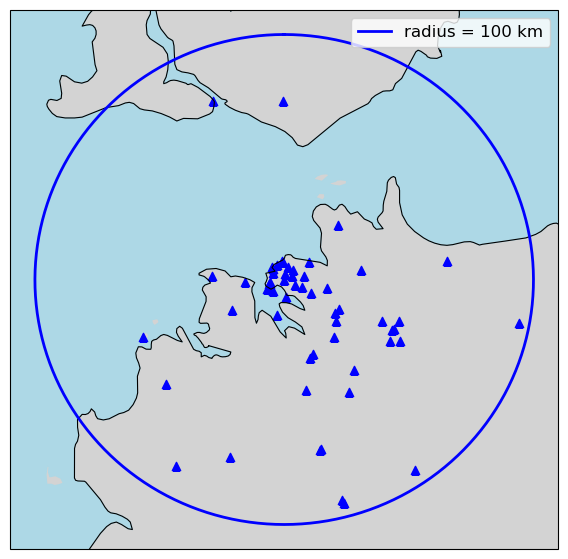

In [82]:
fig = plt.figure(figsize=(16, 7))
ax1 = fig.add_subplot(111, projection=ccrs.PlateCarree())
plt.scatter(df_center["Longitude"], df_center["Latitude"],marker="^", color="blue", transform=ccrs.PlateCarree())

# plt.plot(nearby_bom_lon_1min, nearby_bom_lat_1min, "rx", label = "BoM", transform=ccrs.PlateCarree())
g = cgeod.Geodesic()
circle = g.circle(lon=center_lon, lat=center_lat, radius=center_radius * 1000.0)
## do this to remove the gap of the circle
circ_lon = np.append(circle[:,0], circle[0,0])
circ_lat = np.append(circle[:,1], circle[0,1])
# Plot the circle
ax1.plot(circ_lon, circ_lat, color='blue', transform=ccrs.PlateCarree(), label="radius = 100 km")
plt.legend()
# Add coastlines
ax1.coastlines('10m', color="black", linewidth=0.8)
# Add land and ocean with different colors
ax1.add_feature(cfeature.LAND, color='lightgray')  # Land in light gray
ax1.add_feature(cfeature.OCEAN, color='lightblue')  # Ocean in light blue

In [84]:
min_scale = 0
small_dates_all = []
large_dates_all = []
mid_dates_all = []
extreme_dates_all = []

months = np.arange(0,12)+1
months_str = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]
small_case = np.zeros((months.shape[0], len(df_center["ID"])))
mid_case = np.zeros((months.shape[0], len(df_center["ID"])))
large_case = np.zeros((months.shape[0], len(df_center["ID"])))

for i, spec_id in enumerate(df_center["ID"]):
    df_scale_p90 = pd.read_csv(f"/g/data/k10/dl6968/Semi-variogram_AU/data/all_AU_p90/{spec_id}_pair_scale_list_all_events.csv")
    
    small = np.percentile(df_scale_p90[df_scale_p90["scale"]>min_scale]["scale"].values, 33.3)
    large = np.percentile(df_scale_p90[df_scale_p90["scale"]>min_scale]["scale"].values, 66.6)
    
    small_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>min_scale) & (df_scale_p90["scale"]<=small)]["extreme_dates"] if dates not in small_dates_all]
    mid_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>small) & (df_scale_p90["scale"]<=large)]["extreme_dates"] if dates not in mid_dates_all]
    large_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>large)]["extreme_dates"] if dates not in large_dates_all]
    extreme_dates = [dates for dates in df_scale_p90[(df_scale_p90["scale"]>min_scale)]["extreme_dates"] if dates not in extreme_dates_all]
    
    small_dates_all.extend(small_dates)
    mid_dates_all.extend(mid_dates)
    large_dates_all.extend(large_dates)
    extreme_dates_all.extend(extreme_dates)
    ## seasonality for each station
    for j in range(0,len(small_dates)):
        mon_id = int(small_dates[j][5:7])-1
        small_case[mon_id,i] += 1
    for k in range(0,len(mid_dates)):
        mon_id = int(mid_dates[k][5:7])-1
        mid_case[mon_id,i] += 1
    for l in range(0,len(large_dates)):
        mon_id = int(large_dates[l][5:7])-1
        large_case[mon_id,i] += 1


In [85]:
i =0
for dates in small_dates_all:
    if dates in mid_dates_all:
        i+=1

In [86]:
def calc_ci_2d(data, confidence=0.95, axis=1):
    # Calculate the mean along the specified axis
    means = np.nanmean(data, axis=axis)
    
    # Number of samples along the axis
    n = data.shape[axis]
    
    # Compute the standard error along the specified axis
    std_err = stats.sem(data, axis=axis,nan_policy="omit")
    
    # Calculate the t critical value for the given confidence level
    t_crit = stats.t.ppf((1 + confidence) / 2, df=n - 1)
    
    # Margin of error
    margin_of_error = std_err * t_crit
    
    # Confidence interval bounds
    ci_lower = means - margin_of_error
    ci_upper = means + margin_of_error
    
    return means, ci_lower, ci_upper


In [87]:
small_freq = np.zeros_like(small_case)
mid_freq = np.zeros_like(mid_case)
large_freq = np.zeros_like(large_case)
for j in range(0,small_case.shape[1]):
    small_freq[:,j] = small_case[:,j]/np.sum(small_case[:,j]) *100
    mid_freq[:,j] = mid_case[:,j]/np.sum(mid_case[:,j]) *100
    large_freq[:,j] = large_case[:,j]/np.sum(large_case[:,j]) *100

/jobfs/136384063.gadi-pbs/ipykernel_1851969/700348784.py:7: RuntimeWarning: invalid value encountered in divide
  large_freq[:,j] = large_case[:,j]/np.sum(large_case[:,j]) *100
/jobfs/136384063.gadi-pbs/ipykernel_1851969/700348784.py:6: RuntimeWarning: invalid value encountered in divide
  mid_freq[:,j] = mid_case[:,j]/np.sum(mid_case[:,j]) *100


In [90]:
small_case_mean, small_case_lower, small_case_upper = calc_ci_2d(small_freq)
mid_case_mean, mid_case_lower, mid_case_upper = calc_ci_2d(mid_freq)
large_case_mean, large_case_lower, large_case_upper = calc_ci_2d(large_freq)

In [91]:
small_error =  (small_case_upper - small_case_lower) / 2
mid_error =  (mid_case_upper - mid_case_lower) / 2
large_error =  (large_case_upper - large_case_lower) / 2

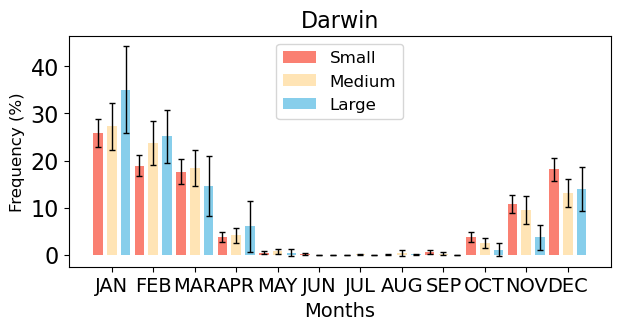

In [96]:
plt.figure(figsize=(7,3))
plt.bar(months*3-1, np.nanmean(small_freq,axis=1), yerr=small_error,color="salmon", label = "Small", 
        width=0.7,capsize=2,error_kw={'elinewidth': 1}) # 
plt.bar(months*3, np.nanmean(mid_freq,axis=1), yerr=mid_error, color="moccasin", label = "Medium",
        width=0.7,capsize=2,error_kw={'elinewidth': 1}) # 

plt.bar(months*3+1, np.nanmean(large_freq,axis=1), yerr=large_error, color="skyblue",label = "Large",
        width=0.7,capsize=2,error_kw={'elinewidth': 1}) # 
plt.legend(loc="upper center")
plt.xlabel("Months",fontsize=14)
plt.ylabel("Frequency (%)",fontsize=12)
plt.title("Darwin")
plt.yticks(fontsize=16)
_ = plt.xticks(months*3,months_str, fontsize=14)